# Echo State Network against Time Series

In [96]:
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader

from qbraid_algorithms.esn import EchoStateNetwork, EchoStateReservoir
from qbraid_algorithms.datasets import create_time_series_data

Format Time Series data to work with the ESN

In [97]:
# Parameters
cycles = 10
n_steps = 10

# Time series creation
trainset = create_time_series_data(1000, cycles, n_steps)
trainloader = DataLoader(trainset, shuffle=True)
testset = create_time_series_data(1000, cycles, n_steps)
testloader = DataLoader(testset, shuffle=False)

Initialize echo state network

In [98]:
input_size = 10
output_size = 1
hyperparams = {
    "hidden_size": 2500,
    "sparsity": 0.9,
    "spectral_radius": 0.99,
    "a": 0.6,
    "leak": 1.0,
}

reservoir = EchoStateReservoir(input_size, **hyperparams)
esn = EchoStateNetwork(reservoir, output_size).float()

Initialize optimizer using ESN parameters, and define loss criterion

In [99]:
criterion = torch.nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(esn.parameters(), lr=0.00001)

Train the network

In [100]:
nsamples = 1000
nepochs = 200
loss_values = []

start = time.time()
for epoch in range(nepochs):
    total_loss = 0.0
    for i, dat in enumerate(trainloader, 0):
        seq = dat[0]
        target = dat[1]

        optimizer.zero_grad()

        output = esn(seq)
        loss = criterion(output, target)

        loss.backward()  # this gotta be tripping
        optimizer.step()
        total_loss += loss.item()
    average_loss = total_loss / nsamples
    loss_values.append(average_loss)
    print(f"epoch {epoch}, loss: {average_loss:.3f}")

    if average_loss < 1e-3:
        break

end = time.time()

seconds = int(end - start)
minutes = seconds // 60
print(f"Training duration: {minutes} min {seconds % 60} sec")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0, loss: 0.055
epoch 1, loss: 0.009
epoch 2, loss: 0.007
epoch 3, loss: 0.005
epoch 4, loss: 0.005
epoch 5, loss: 0.004
epoch 6, loss: 0.004
epoch 7, loss: 0.003
epoch 8, loss: 0.003
epoch 9, loss: 0.003
epoch 10, loss: 0.003
epoch 11, loss: 0.002
epoch 12, loss: 0.002
epoch 13, loss: 0.002
epoch 14, loss: 0.002
epoch 15, loss: 0.002
epoch 16, loss: 0.002
epoch 17, loss: 0.002
epoch 18, loss: 0.002
epoch 19, loss: 0.002
epoch 20, loss: 0.002
epoch 21, loss: 0.002
epoch 22, loss: 0.002
epoch 23, loss: 0.002
epoch 24, loss: 0.002
epoch 25, loss: 0.002
epoch 26, loss: 0.001
epoch 27, loss: 0.001
epoch 28, loss: 0.002
epoch 29, loss: 0.002
epoch 30, loss: 0.002
epoch 31, loss: 0.001
epoch 32, loss: 0.001
epoch 33, loss: 0.001
epoch 34, loss: 0.001
epoch 35, loss: 0.001
epoch 36, loss: 0.001
epoch 37, loss: 0.001
epoch 38, loss: 0.001
epoch 39, loss: 0.001
epoch 40, loss: 0.001
epoch 41, loss: 0.001
epoch 42, loss: 0.001
epoch 43, loss: 0.001
epoch 44, loss: 0.001
epoch 45, loss: 0.00

Plot the loss

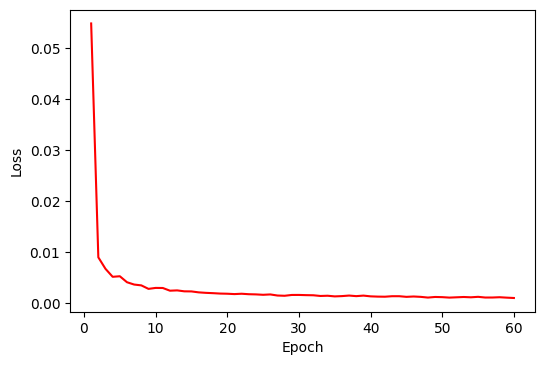

In [101]:
fig, ax = plt.subplots(dpi=100)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.plot(range(1, len(loss_values) + 1), loss_values, color="red")
plt.show()

Plot against desired data, giving R^2 as well

R^2: 0.6219144930099256


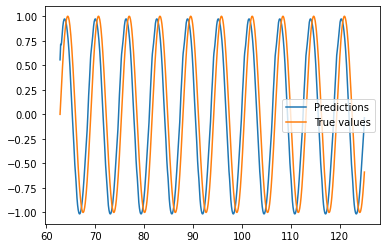

In [104]:
esn.eval()
predictions = []

with torch.no_grad():
    for inputs, targets in testloader:
        output = esn(inputs)[0]
        predictions.append(output)

t_test = np.linspace(2 * np.pi * 10, 2 * np.pi * 20, 1000)

plt.plot(t_test[:990], torch.cat(predictions).numpy(), label="Predictions")
plt.plot(t_test[:990], np.sin(t_test)[:990], label="True values")
plt.legend()